# Diamond EP Grouping by Resolution Limit - Feature Selection


Try to identify which features help model, and try to leave out uninformative features

In [1]:
import sys
import os
dirpath = r'C:\Users\César\PycharmProjects\Diamond_ML'
if dirpath not in sys.path:
    sys.path.insert(0, dirpath)
from read_data import data, pd, np, plt, plot_original_data
plt.style.use("ggplot")

Want to see which features are more important. Already have correlations table, but now fit optimised random forest and see which features are most important. The computations were done on a 1000 iteration RandomisedSearch on the DLS computer cluster.

DIALS


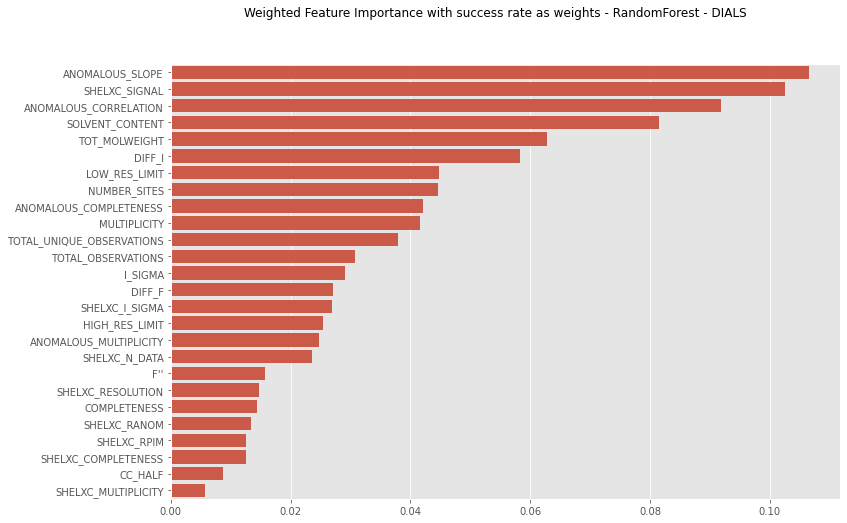

------------------------------------------------------------
3DII


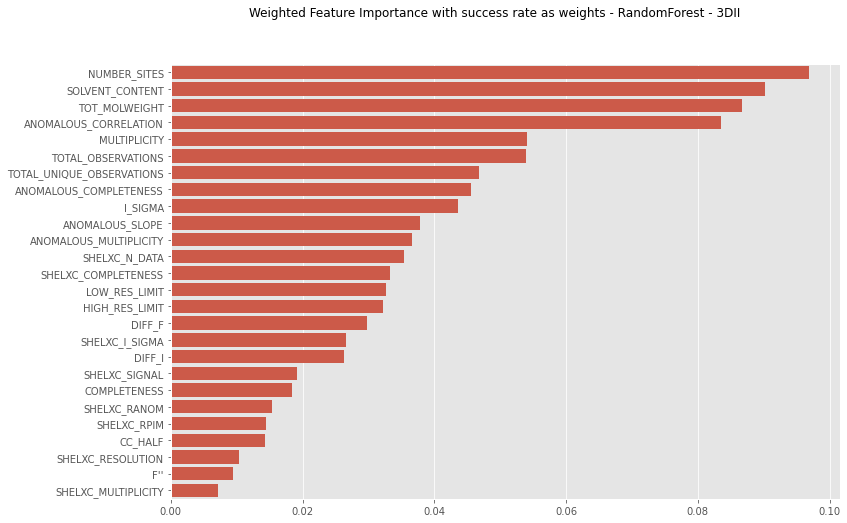

------------------------------------------------------------


In [73]:
import seaborn as sns


for db_kind in ["dials", "3dii"]:
    print(db_kind.upper())
    topfeats, weights,  = [], []
    
    # loop through every dataset
    for i in np.arange(1, 101):
        db_dir = fr"D:\Diamond\analysis\results\dataset_{i}\{db_kind}"
        
        # try to get feature importance csv data
        try:
            topfeat = pd.read_csv(os.path.join(db_dir, "topfeat.csv"), squeeze=True, index_col=0)
            cols = topfeat.index
            topfeats.append(topfeat.values.tolist())
            
            # get target for success rate to be used as weight
            y = data[db_kind].y
            success_rate = y.sum() / y.size
            weights.append(success_rate)
            
        # default to 0 if not found
        except FileNotFoundError:
            topfeats.append([0 for i in range(len(cols))])
            weights.append(0)

    
    # organise and sort top features
    topfeats = np.array(topfeats)
    topfeats_avg = np.average(topfeats, weights=weights, axis=0)
    topfeats_avg = pd.Series(topfeats_avg, index=cols).sort_values(ascending=False)
    
    # create figure
    plt.figure(figsize=(12, 8))
    plt.suptitle(f"Weighted Feature Importance with success rate as weights - RandomForest - {db_kind.upper()}")
    sns.barplot(x=topfeats_avg.values, y=topfeats_avg.index, color="C0")
    plt.show()
    
    print("-"*60)

## Method 1: Individual Removal

Here we will attempt to both perform PCA on, and remove, individual (or groups of) features to see if the model performance varies.

If there is **no significant variation** then that indicates that the removed features are **irrelevant** to the model. If the performance **decreases** they are **important**, and if it **increases** they are **detrimental**.

DIALS
Removing features: ["F''"]
Normal
> F1 Score: 67.96% +- 3.48%
> MCC: 54.84% +- 4.97%
PCA
> F1 Score: 67.90% +- 3.75%
> MCC: 54.74% +- 4.98%
Remove
> F1 Score: 67.47% +- 3.05%
> MCC: 54.19% +- 3.98%


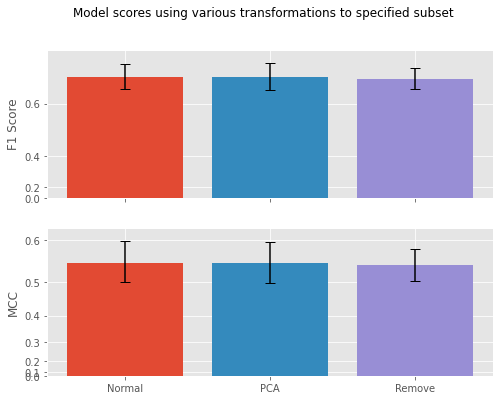

3DII
Removing features: ["F''"]
Normal
> F1 Score: 70.93% +- 0.63%
> MCC: 39.72% +- 1.60%
PCA
> F1 Score: 71.10% +- 0.40%
> MCC: 39.61% +- 0.98%
Remove
> F1 Score: 70.93% +- 0.50%
> MCC: 39.59% +- 1.53%


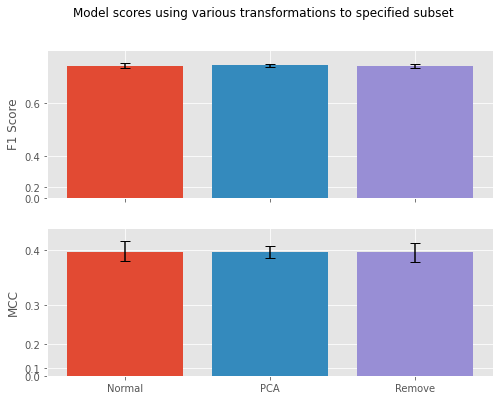

In [34]:
import seaborn as sns
from pca import pca as PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import matthews_corrcoef, f1_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint, uniform, sem
mcc = make_scorer(matthews_corrcoef)


def test_normal_pca_remove(estimator, X, y, feat2test, show=True, show_pca=False, random_state=None):
    # do PCA on two features
    pca = PCA(normalize=True, n_components=0.95)
    new = pca.fit_transform(X.loc[:, feat2test], verbose=2)
    if show_pca:
        pca.plot()

    # get new data subsets
    X_remove = X.drop(feat2test, axis=1)
    X_pca = X_remove.copy()
    X_pca = pd.concat([X_pca, new["PC"]], axis=1)
    
    # prepare figure
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
    
    for i, (x_part, name) in enumerate(zip([X, X_pca, X_remove], ["Normal", "PCA", "Remove"])):
        print(name)
        
        f1s = cross_val_score(forest, x_part, y, scoring='f1', cv=5, n_jobs=-1)
        mccs = cross_val_score(forest, x_part, y, scoring=mcc, cv=5, n_jobs=-1)
        f1_val, f1_err = f1s.mean(), sem(f1s)
        mcc_val, mcc_err = mccs.mean(), sem(mccs)
        
        ax1.bar(i, f1_val, yerr=f1_err, capsize=5)
        ax2.bar(i, mcc_val, yerr=mcc_err, capsize=5)
        
        print(f"> F1 Score: {f1_val:.2%} +- {f1_err:.2%}\n"
              f"> MCC: {mcc_val:.2%} +- {mcc_err:.2%}")
    
    # labels
    ax1.set_ylabel("F1 Score")
    ax2.set_ylabel("MCC")
    ax2.set_xticks([0, 1, 2])
    ax2.set_xticklabels(["Normal", "PCA", "Remove"])
    fig.suptitle(f"Model scores using various transformations to specified subset")
    
    if show:
        plt.show()
    return fig, (ax1, ax2)
    

seed = 2

for db_kind, datum in data.items():
    print(db_kind.upper())
    r_etc = ["RMERGE_I", "RMERGE_DIFF_I", "RMEAS_I", "RMEAS_DIFF_I", "RPIM_I", "RPIM_DIFF_I"]
    x, y = datum.unpack(drop_col=["DATASET_id", "SHELXC_CFOM", "SPACEGROUP"])
    
    # take only untouched data
    i = 1
    mask = x["DATASET_NAME"] == i
    x, y, = x[mask], y[mask]
    x = x.drop(["DATASET_NAME"], axis=1)
    
    # get relevant features
    feats2test = ["F''"]
    print(f"Removing features: {feats2test}")
    x_part = x[feats2test]
    union_part = pd.concat([x_part, y], axis=1)
    
    # plot scatter plot
    #sns.lmplot(data=union_part, x="SHELXC_RPIM", y="SHELXC_RANOM", hue="IS_SUCCESS")
    #plt.show()
    
    # create model
    n_iter = 50
    forest = Pipeline([("scaler", StandardScaler()), ("clf", RandomForestClassifier(class_weight="balanced", random_state=seed))])
    forest_params = {"clf__criterion": ["gini", "entropy"],
                     "clf__n_estimators": randint(100, 10000),  # number of trees in forest
                     "clf__max_features": uniform(2/ len(x.columns), 1),  # max number of features when splitting
                     "clf__min_samples_split": randint(2, 20 + 1),  # min samples per node to induce split
                     "clf__max_depth": randint(5, 20 + 1),  # max number of splits to do
                     "clf__min_samples_leaf": randint(1, 10 + 1),  # min number of samples in a leaf; may set to 1 anyway
                     "clf__max_leaf_nodes": randint(10, 20 + 1)}  # max number of leaves}
    forest_search = RandomizedSearchCV(forest, forest_params, n_iter=n_iter, scoring="f1", n_jobs=-1, cv=5, random_state=seed)

    # test various features transforms
    fig, (ax1, ax2) = test_normal_pca_remove(forest_search, x, y, feats2test, show=False)
    ax1.set_yscale('function', functions=(lambda a: a**2, lambda a: a**.5))
    ax2.set_yscale('function', functions=(lambda a: a**2, lambda a: a**.5))
    
    plt.show()

Scores equivalent for all - no performance change. F'' is **irrelevant**.

Now test for RMERGE/RMEAS/RPIM (DIFF) I.

DIALS
Removing features: ['RMERGE_I', 'RMERGE_DIFF_I', 'RMEAS_I', 'RMEAS_DIFF_I', 'RPIM_I', 'RPIM_DIFF_I']


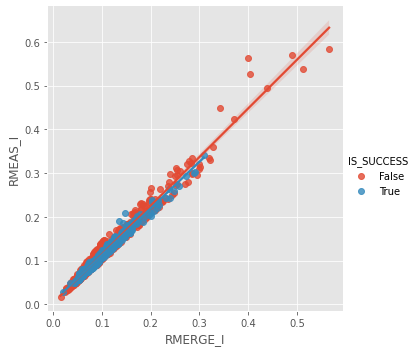

Normal
> F1 Score: 67.47% +- 3.05%
> MCC: 54.19% +- 3.98%
PCA
> F1 Score: 68.03% +- 3.68%
> MCC: 54.48% +- 5.01%
Remove
> F1 Score: 68.23% +- 4.03%
> MCC: 54.90% +- 5.55%


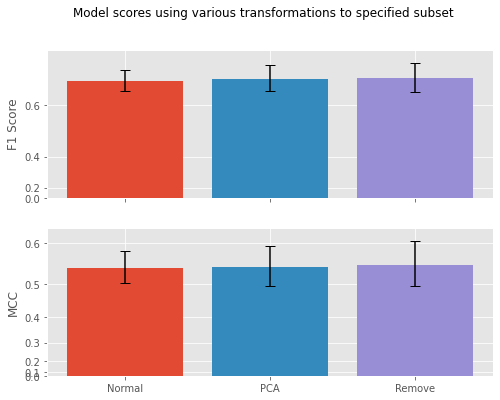

3DII
Removing features: ['RMERGE_I', 'RMERGE_DIFF_I', 'RMEAS_I', 'RMEAS_DIFF_I', 'RPIM_I', 'RPIM_DIFF_I']


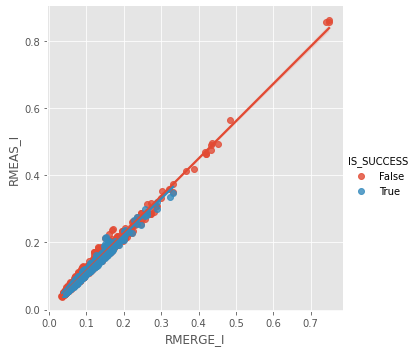

Normal
> F1 Score: 70.93% +- 0.50%
> MCC: 39.59% +- 1.53%
PCA
> F1 Score: 70.84% +- 0.53%
> MCC: 39.27% +- 1.37%
Remove
> F1 Score: 70.58% +- 0.94%
> MCC: 39.00% +- 1.13%


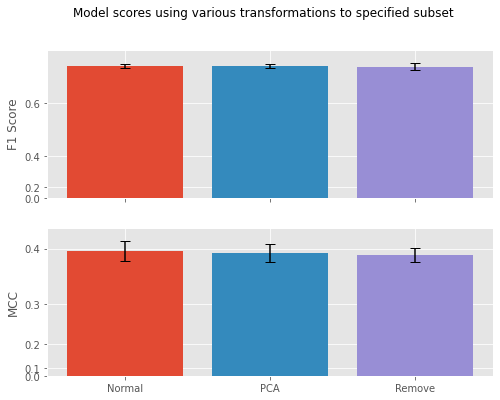

In [26]:
for db_kind, datum in data.items():
    print(db_kind.upper())
    r_etc = ["RMERGE_I", "RMERGE_DIFF_I", "RMEAS_I", "RMEAS_DIFF_I", "RPIM_I", "RPIM_DIFF_I"]
    x, y = datum.unpack(drop_col=["DATASET_id", "SHELXC_CFOM", "SPACEGROUP", "F''"])
    
    # take only untouched data
    i = 1
    mask = x["DATASET_NAME"] == i
    x, y, = x[mask], y[mask]
    x = x.drop(["DATASET_NAME"], axis=1)
    
    # get relevant features
    feats2test = ["RMERGE_I", "RMERGE_DIFF_I", "RMEAS_I", "RMEAS_DIFF_I", "RPIM_I", "RPIM_DIFF_I"]
    print(f"Removing features: {feats2test}")
    x_part = x[feats2test]
    union_part = pd.concat([x_part, y], axis=1)
    
    # plot scatter plot
    seed = 2
    sns.lmplot(data=union_part, x="RMERGE_I", y="RMEAS_I", hue="IS_SUCCESS")
    plt.show()
    
    # create model
    n_iter = 50
    forest = Pipeline([("scaler", StandardScaler()), ("clf", RandomForestClassifier(class_weight="balanced", random_state=seed))])
    forest_params = {"clf__criterion": ["gini", "entropy"],
                     "clf__n_estimators": randint(100, 10000),  # number of trees in forest
                     "clf__max_features": uniform(2/ len(x.columns), 1),  # max number of features when splitting
                     "clf__min_samples_split": randint(2, 20 + 1),  # min samples per node to induce split
                     "clf__max_depth": randint(5, 20 + 1),  # max number of splits to do
                     "clf__min_samples_leaf": randint(1, 10 + 1),  # min number of samples in a leaf; may set to 1 anyway
                     "clf__max_leaf_nodes": randint(10, 20 + 1)}  # max number of leaves}
    forest_search = RandomizedSearchCV(forest, forest_params, n_iter=n_iter, scoring="f1", n_jobs=-1, cv=5, random_state=seed)

    # test various features transforms
    fig, (ax1, ax2) = test_normal_pca_remove(forest_search, x, y, feats2test, show=False)
    ax1.set_yscale('function', functions=(lambda a: a**2, lambda a: a**.5))
    ax2.set_yscale('function', functions=(lambda a: a**2, lambda a: a**.5))
    
    plt.show()

A slight decrease in MCC can be seen, however this decrease disappears when the seed is varied. These feature also appear to be **irrelevant**.

Now test SHELXC_RPIM/RANOM

DIALS
Removing features: ['SHELXC_RANOM', 'SHELXC_RPIM']


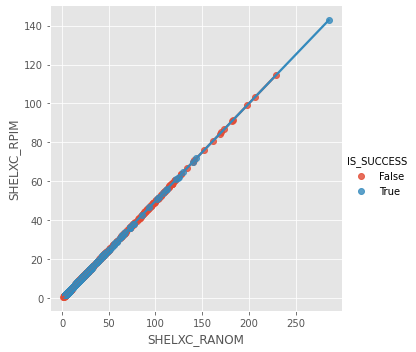

Normal
> F1 Score: 68.23% +- 4.03%
> MCC: 54.90% +- 5.55%
PCA
> F1 Score: 68.77% +- 3.49%
> MCC: 55.48% +- 5.07%
Remove
> F1 Score: 69.94% +- 3.32%
> MCC: 57.32% +- 4.97%


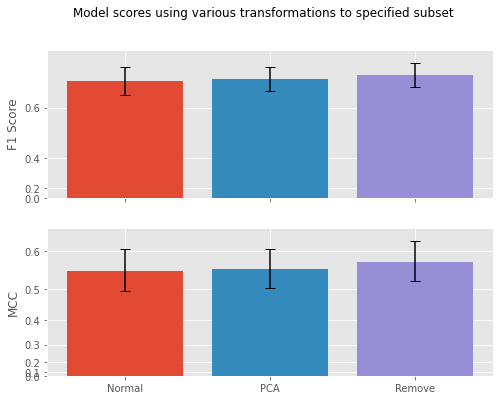

3DII
Removing features: ['SHELXC_RANOM', 'SHELXC_RPIM']


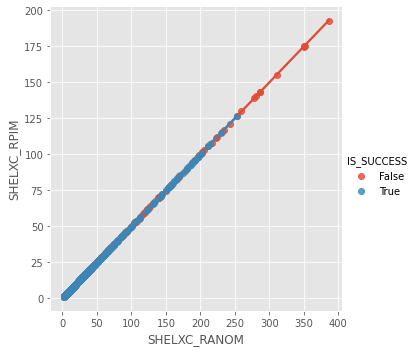

Normal
> F1 Score: 70.58% +- 0.94%
> MCC: 39.00% +- 1.13%
PCA
> F1 Score: 71.06% +- 0.97%
> MCC: 39.92% +- 1.85%
Remove
> F1 Score: 72.04% +- 0.76%
> MCC: 41.46% +- 1.47%


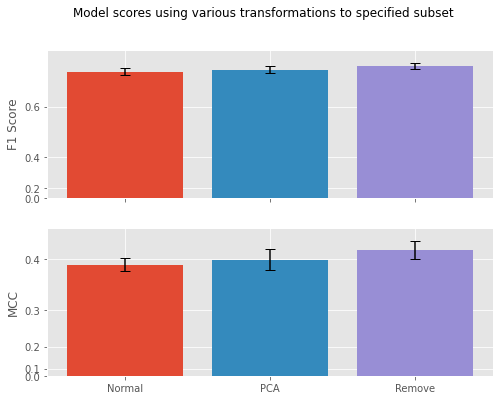

In [28]:
for db_kind, datum in data.items():
    print(db_kind.upper())
    r_etc = ["RMERGE_I", "RMERGE_DIFF_I", "RMEAS_I", "RMEAS_DIFF_I", "RPIM_I", "RPIM_DIFF_I"]
    x, y = datum.unpack(drop_col=["DATASET_id", "SHELXC_CFOM", "SPACEGROUP", "F''"] + r_etc)
    
    # take only untouched data
    i = 1
    mask = x["DATASET_NAME"] == i
    x, y, = x[mask], y[mask]
    x = x.drop(["DATASET_NAME"], axis=1)
    
    # get relevant features
    feats2test = ["SHELXC_RANOM", "SHELXC_RPIM"]
    print(f"Removing features: {feats2test}")
    x_part = x[feats2test]
    union_part = pd.concat([x_part, y], axis=1)
    
    # plot scatter plot
    seed = 2
    sns.lmplot(data=union_part, x=feats2test[0], y=feats2test[1], hue="IS_SUCCESS")
    plt.show()
    
    # create model
    n_iter = 50
    forest = Pipeline([("scaler", StandardScaler()), ("clf", RandomForestClassifier(class_weight="balanced", random_state=seed))])
    forest_params = {"clf__criterion": ["gini", "entropy"],
                     "clf__n_estimators": randint(100, 10000),  # number of trees in forest
                     "clf__max_features": uniform(2/ len(x.columns), 1),  # max number of features when splitting
                     "clf__min_samples_split": randint(2, 20 + 1),  # min samples per node to induce split
                     "clf__max_depth": randint(5, 20 + 1),  # max number of splits to do
                     "clf__min_samples_leaf": randint(1, 10 + 1),  # min number of samples in a leaf; may set to 1 anyway
                     "clf__max_leaf_nodes": randint(10, 20 + 1)}  # max number of leaves}
    forest_search = RandomizedSearchCV(forest, forest_params, n_iter=n_iter, scoring="f1", n_jobs=-1, cv=5, random_state=seed)

    # test various features transforms
    fig, (ax1, ax2) = test_normal_pca_remove(forest_search, x, y, feats2test, show=False)
    ax1.set_yscale('function', functions=(lambda a: a**2, lambda a: a**.5))
    ax2.set_yscale('function', functions=(lambda a: a**2, lambda a: a**.5))
    
    plt.show()

This appears to be similar to before, which we determined to be irrelevant features to the model. We will also discard them, since they appear **irrelevant** or even **detrimental**.

Now try to remove features that we KNOW are relevant to the model. These vary between DIALS and XDS, but for DIALS we choose the **HR limit, SHELXC signal, Anomalous correlation/slope**.

DIALS
Removing features: ['HIGH_RES_LIMIT', 'SHELXC_SIGNAL', 'ANOMALOUS_CORRELATION', 'ANOMALOUS_SLOPE']


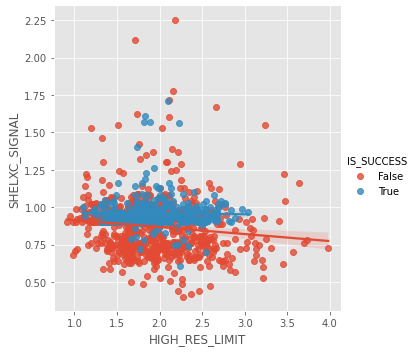

Normal
> F1 Score: 67.47% +- 3.05%
> MCC: 54.19% +- 3.98%
PCA
> F1 Score: 66.42% +- 3.30%
> MCC: 53.00% +- 4.50%
Remove
> F1 Score: 63.12% +- 2.78%
> MCC: 50.06% +- 3.66%


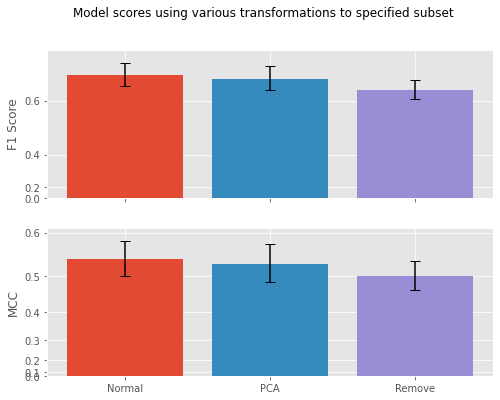

3DII
Removing features: ['HIGH_RES_LIMIT', 'SHELXC_SIGNAL', 'ANOMALOUS_CORRELATION', 'ANOMALOUS_SLOPE']


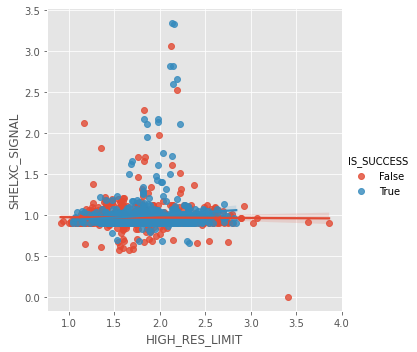

Normal
> F1 Score: 70.93% +- 0.50%
> MCC: 39.59% +- 1.53%
PCA
> F1 Score: 70.90% +- 0.82%
> MCC: 40.33% +- 1.65%
Remove
> F1 Score: 70.78% +- 0.58%
> MCC: 39.60% +- 1.79%


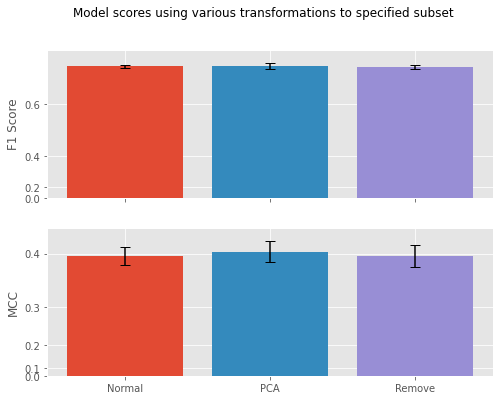

In [29]:
for db_kind, datum in data.items():
    print(db_kind.upper())
    r_etc = ["RMERGE_I", "RMERGE_DIFF_I", "RMEAS_I", "RMEAS_DIFF_I", "RPIM_I", "RPIM_DIFF_I"]
    x, y = datum.unpack(drop_col=["DATASET_id", "SHELXC_CFOM", "SPACEGROUP", "F''"])
    
    # take only untouched data
    i = 1
    mask = x["DATASET_NAME"] == i
    x, y, = x[mask], y[mask]
    x = x.drop(["DATASET_NAME"], axis=1)
    
    # get relevant features
    feats2test = ["HIGH_RES_LIMIT", "SHELXC_SIGNAL", "ANOMALOUS_CORRELATION", "ANOMALOUS_SLOPE"]
    print(f"Removing features: {feats2test}")
    x_part = x[feats2test]
    union_part = pd.concat([x_part, y], axis=1)
    
    # plot scatter plot
    seed = 2
    sns.lmplot(data=union_part, x=feats2test[0], y=feats2test[1], hue="IS_SUCCESS")
    plt.show()
    
    # create model
    n_iter = 50
    forest = Pipeline([("scaler", StandardScaler()), ("clf", RandomForestClassifier(class_weight="balanced", random_state=seed))])
    forest_params = {"clf__criterion": ["gini", "entropy"],
                     "clf__n_estimators": randint(100, 10000),  # number of trees in forest
                     "clf__max_features": uniform(2/ len(x.columns), 1),  # max number of features when splitting
                     "clf__min_samples_split": randint(2, 20 + 1),  # min samples per node to induce split
                     "clf__max_depth": randint(5, 20 + 1),  # max number of splits to do
                     "clf__min_samples_leaf": randint(1, 10 + 1),  # min number of samples in a leaf; may set to 1 anyway
                     "clf__max_leaf_nodes": randint(10, 20 + 1)}  # max number of leaves}
    forest_search = RandomizedSearchCV(forest, forest_params, n_iter=n_iter, scoring="f1", n_jobs=-1, cv=5, random_state=seed)

    # test various features transforms
    fig, (ax1, ax2) = test_normal_pca_remove(forest_search, x, y, feats2test, show=False)
    ax1.set_yscale('function', functions=(lambda a: a**2, lambda a: a**.5))
    ax2.set_yscale('function', functions=(lambda a: a**2, lambda a: a**.5))
    
    plt.show()

As predicted, performance decreases for DIALS, but remains relatively constant for XDS, since the latter gives more importance to other features.

Note that the decrease in DIALS performance does not disappear by varying the seed. As such, these features are **important** for DIALS.


## Method 2: RFECV

Now try more complex feature selection methods.

First make use of the **R**ecursive **F**eature **E**limination **C**ross-**V**alidated model (RFECV). This model uses the feature_importances_ or coef_ properties of the classifier to determine the most/least important features and recursively remove the least important ones, giving a score to each feature subset.

The performance can then be plotted as a function of no. features, and the optimal features found.

The parameters chosen were the best parameters found using a 1000 iteration RandomizedSearch on the DLS cluster.

DIALS
Dropped 39.97% samples
(721, 34)
criterion            entropy
max_depth                 10
max_leaf_nodes            15
min_samples_leaf           1
min_samples_split          2
n_estimators             875
Name: 0, dtype: object
Testing removing features: Index(['F''', 'MULTIPLICITY', 'RMERGE_DIFF_I', 'RMEAS_DIFF_I', 'CC_HALF',
       'ANOMALOUS_MULTIPLICITY', 'SHELXC_MULTIPLICITY'],
      dtype='object')
Normal
> F1 Score: 71.87% +- 4.36%
> MCC: 57.07% +- 6.23%
PCA
> F1 Score: 70.07% +- 5.25%
> MCC: 55.37% +- 7.08%
Remove


<ipython-input-24-fdc6bfe4e323>:61: RuntimeWarning: invalid value encountered in sqrt
  ax2.set_yscale('function', functions=(lambda a: a**2, lambda a: a**.5))
C:\Users\César\AppData\Roaming\Python\Python38\site-packages\matplotlib\transforms.py:2623: RuntimeWarning: divide by zero encountered in double_scalars
  y_scale = 1.0 / inh
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


> F1 Score: 71.98% +- 4.85%
> MCC: 57.34% +- 6.52%


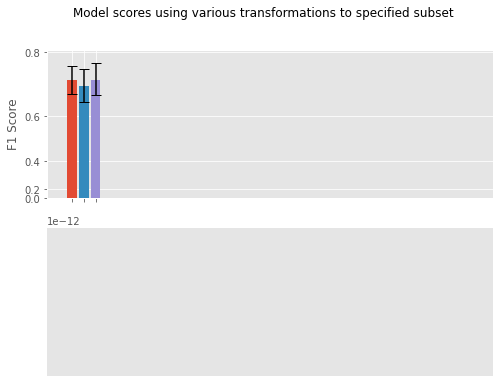

ANOMALOUS_SLOPE              1
TOT_MOLWEIGHT                1
NUMBER_SITES                 1
SOLVENT_CONTENT              1
SHELXC_SIGNAL                1
SHELXC_RANOM                 1
SHELXC_RPIM                  1
SHELXC_COMPLETENESS          1
SHELXC_I_SIGMA               1
SHELXC_N_DATA                1
SHELXC_RESOLUTION            1
TOTAL_UNIQUE_OBSERVATIONS    1
TOTAL_OBSERVATIONS           1
DIFF_I                       1
DIFF_F                       1
RESOLUTION_LOW               1
RESOLUTION_HIGH              1
ANOMALOUS_COMPLETENESS       1
HIGH_RES_LIMIT               1
RPIM_DIFF_I                  1
RPIM_I                       1
RMEAS_I                      1
ANOMALOUS_CORRELATION        1
RMERGE_I                     1
I_SIGMA                      1
COMPLETENESS                 1
LOW_RES_LIMIT                1
MULTIPLICITY                 2
RMERGE_DIFF_I                3
RMEAS_DIFF_I                 4
ANOMALOUS_MULTIPLICITY       5
F''                          6
CC_HALF 

<ipython-input-24-fdc6bfe4e323>:61: RuntimeWarning: invalid value encountered in sqrt
  ax2.set_yscale('function', functions=(lambda a: a**2, lambda a: a**.5))
C:\Users\César\AppData\Roaming\Python\Python38\site-packages\matplotlib\transforms.py:2623: RuntimeWarning: divide by zero encountered in double_scalars
  y_scale = 1.0 / inh
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


> F1 Score: 73.74% +- 1.26%
> MCC: 44.86% +- 2.83%


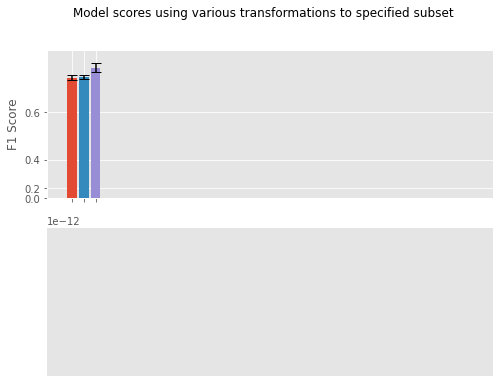

RESOLUTION_HIGH               1
HIGH_RES_LIMIT                1
TOT_MOLWEIGHT                 1
COMPLETENESS                  1
MULTIPLICITY                  1
NUMBER_SITES                  1
SHELXC_COMPLETENESS           1
SHELXC_N_DATA                 1
RMEAS_DIFF_I                  1
TOTAL_UNIQUE_OBSERVATIONS     1
ANOMALOUS_CORRELATION         1
ANOMALOUS_COMPLETENESS        1
ANOMALOUS_MULTIPLICITY        1
RMERGE_DIFF_I                 2
TOTAL_OBSERVATIONS            3
ANOMALOUS_SLOPE               4
RESOLUTION_LOW                5
I_SIGMA                       6
RPIM_DIFF_I                   7
SHELXC_RESOLUTION             8
DIFF_I                        9
SOLVENT_CONTENT              10
RMERGE_I                     11
LOW_RES_LIMIT                12
RPIM_I                       13
SHELXC_RANOM                 14
RMEAS_I                      15
SHELXC_I_SIGMA               16
DIFF_F                       17
SHELXC_RPIM                  18
CC_HALF                      19
SHELXC_S

In [24]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.neighbors import LocalOutlierFactor as LOF
from scipy.optimize import curve_fit


def exp_dec_inv(data, a, b):
    return b * (1 - np.exp(a * data))



for db_kind, datum in data.items():
    print(db_kind.upper())
    r_etc = ["RMERGE_I", "RMERGE_DIFF_I", "RMEAS_I", "RMEAS_DIFF_I", "RPIM_I", "RPIM_DIFF_I"]
    x, y = datum.unpack(drop_col=["DATASET_id", "SHELXC_CFOM", "SPACEGROUP"])
    
    # take only untouched data
    i = 1
    mask = x["DATASET_NAME"] == i
    x, y, = x[mask], y[mask]
    x = x.drop(["DATASET_NAME"], axis=1)
    
    # remove outliers
    if db_kind == "dials":
        liers = LOF(contamination=0.4).fit_predict(x)
        mask = liers == 1
        print(f"Dropped {1-mask.sum()/mask.size:.2%} samples")
        x, y = x.loc[mask, :], y[mask]
    print(x.shape)
    
    # prepare best params
    db_dir = fr"D:\Diamond\analysis\results\dataset_{i}\{db_kind}\confidence_threshold"
    best_params = pd.read_csv(os.path.join(db_dir, "best_params_RandomForest.csv"), squeeze=True, index_col=0)
    best_params.index = best_params.index.str.replace("clf__", "")
    best_params.drop("max_features", inplace=True)  # bug with RFECV
    for ix, val in best_params.items():
        try:
            best_params[ix] = int(val)
        except ValueError:
            continue
    print(best_params)
    
    # create estimators
    seed = 1
    clf = RandomForestClassifier(random_state=seed, class_weight="balanced", **best_params)
    model = Pipeline([("scaler", StandardScaler()), ("clf", clf)])
        
    # separate into train/test datasets and train model
    X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=seed)
    
    # select best features
    selector = RFECV(model, n_jobs=4, cv=5, scoring="f1",
                     importance_getter="named_steps.clf.feature_importances_")
    selector.fit(X_train, y_train)
    feats2test = x.columns[~selector.support_]
    print("Testing removing features:", feats2test)
    
    # test performance removing bad features
    fig, (ax1, ax2) = test_normal_pca_remove(model, X_test, y_test, feats2test, show=False)
    ax1.set_yscale('function', functions=(lambda a: a**2, lambda a: a**.5))
    ax2.set_yscale('function', functions=(lambda a: a**2, lambda a: a**.5))
    
    
    # fit optimal curve to data
    hoz, ver = np.arange(1, len(selector.grid_scores_) + 1), selector.grid_scores_
    # popt, pcov = curve_fit(exp_dec_inv, hoz, ver, bounds=([0, 0], [2, 1]), p0=[0.7, 1])
    # print(popt)
    
    # plot results
    fig, ax = plt.subplots()
    ax.scatter(hoz, ver)
    ax.set_xlabel("Number of features selected")
    ax.set_ylabel("Cross validation score")
    
    # plot best fit curve
    # plt.plot(hoz, exp_dec_inv(hoz, *popt))
    plt.show()
    
    ranking = pd.Series(selector.ranking_, index=x.columns)
    print(ranking.sort_values())
    print(f"Optimal number of features: {sum(selector.support_)}")
    
    print("-"*60)

RFECV does manage to improve model performance. The importance given to each feature varies a bit, but there a few that agree with the feature importance graph previously found. This will be discussed after method 3.


## Method 3: Permutation Importance

This method first gets a **baseline** score, obtained by the normal sore on the regular dataset. The samples of each feature are then permutated and a score obtained. If the score is **similar** to the baseline, then that feature isn't important to model performance, it is **irrelevant**. Otherwise, if the score is lower, then that feature is **important** to the model.

The sklearn function automatically takes the difference between baseline and each feature's score to identify the most important one.

DIALS
Dropped 39.97% samples
(721, 34)
criterion            entropy
max_depth                 10
max_features              18
max_leaf_nodes            15
min_samples_leaf           1
min_samples_split          2
n_estimators             875
Name: 0, dtype: object


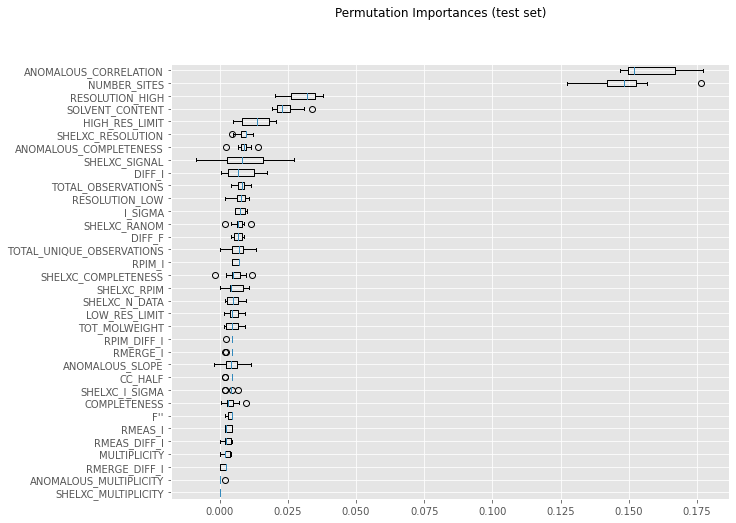

------------------------------------------------------------
3DII
(1450, 34)
criterion            entropy
max_depth                  7
max_features              21
max_leaf_nodes            20
min_samples_leaf           1
min_samples_split         11
n_estimators            7154
Name: 0, dtype: object


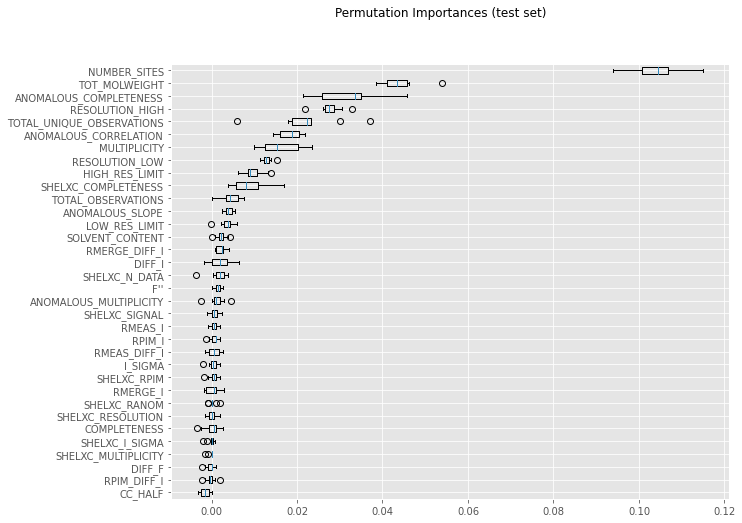

------------------------------------------------------------


In [15]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score, matthews_corrcoef
from sklearn.neighbors import LocalOutlierFactor as LOF


for db_kind, datum in data.items():
    print(db_kind.upper())
    r_etc = ["RMERGE_I", "RMERGE_DIFF_I", "RMEAS_I", "RMEAS_DIFF_I", "RPIM_I", "RPIM_DIFF_I"]
    x, y = datum.unpack(drop_col=["DATASET_id", "SHELXC_CFOM", "SPACEGROUP"])
    
    # take only untouched data
    i = 1
    mask = x["DATASET_NAME"] == i
    x, y, = x[mask], y[mask]
    x = x.drop(["DATASET_NAME"], axis=1)
    
    # remove outliers
    if db_kind == "dials":
        liers = LOF(contamination=0.4).fit_predict(x)
        mask = liers == 1
        print(f"Dropped {1-mask.sum()/mask.size:.2%} samples")
        x, y = x.loc[mask, :], y[mask]
    print(x.shape)
    
    # prepare best params
    db_dir = fr"D:\Diamond\analysis\results\dataset_{i}\{db_kind}\confidence_threshold"
    best_params = pd.read_csv(os.path.join(db_dir, "best_params_RandomForest.csv"), squeeze=True, index_col=0)
    best_params.index = best_params.index.str.replace("clf__", "")
    for ix, val in best_params.items():
        try:
            best_params[ix] = int(val)
        except ValueError:
            continue
    print(best_params)
    best_params = best_params.to_dict()
    
    # create estimators
    seed = 1
    clf = RandomForestClassifier(random_state=seed, class_weight="balanced", **best_params)
    model = Pipeline([("scaler", StandardScaler()), ("clf", clf)])
    
    
    # separate into train/test datasets and train model
    X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=seed)
    
    # select best features
    model.fit(X_train, y_train)
    selector = permutation_importance(model, X_train, y_train, n_jobs=4,
                                      scoring="f1", n_repeats=10, random_state=seed)
    sorted_idx = selector.importances_mean.argsort()
    
    # plot results
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.boxplot(selector.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx])
    fig.suptitle("Permutation Importances (test set)")
    plt.show()
    
    print("-"*60)

DIALS appears to value **anomalous correlation, number of sites, HR limit and solvent content** more than other features. While XDS values the **number of sites, total molecular weight, anomalous completeness and HR limit**, followed by a few others (including total unique observations, anomalous correlation, and LR limit).


## Final Test

So far a few features have consistently had (generally) **low importance** throughout every methods. These are:

- RMERGE/RPIM/RMEAS (DIFF) I
- SHELXC RPIM/RANOM
- F''
- CC HALF
- SHELXC MULTIPLICITY

I will attempt a final test of removing all of these features and seeing how the model performance is affected.

DIALS
Removing features: ['RMERGE_I', 'RMERGE_DIFF_I', 'RMEAS_I', 'RMEAS_DIFF_I', 'RPIM_I', 'RPIM_DIFF_I', 'SHELXC_RPIM', 'SHELXC_RANOM', 'SHELXC_MULTIPLICITY', "F''", 'CC_HALF']


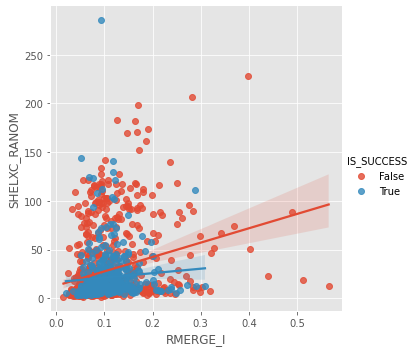

criterion            entropy
max_depth                 10
max_features              18
max_leaf_nodes            15
min_samples_leaf           1
min_samples_split          2
n_estimators             875
Name: 0, dtype: object
Normal
> F1 Score: 67.96% +- 3.48%
> MCC: 54.84% +- 4.97%
PCA
> F1 Score: 68.53% +- 3.93%
> MCC: 55.36% +- 5.44%
Remove
> F1 Score: 67.89% +- 4.10%
> MCC: 54.52% +- 5.74%


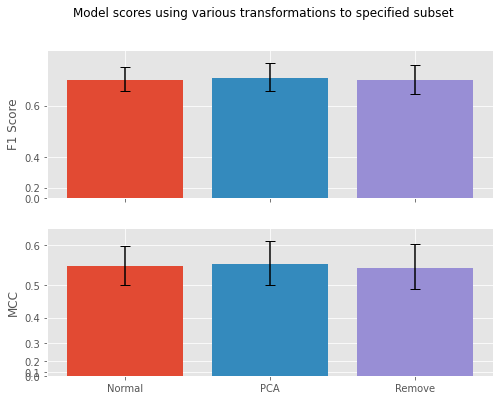

3DII
Removing features: ['RMERGE_I', 'RMERGE_DIFF_I', 'RMEAS_I', 'RMEAS_DIFF_I', 'RPIM_I', 'RPIM_DIFF_I', 'SHELXC_RPIM', 'SHELXC_RANOM', 'SHELXC_MULTIPLICITY', "F''", 'CC_HALF']


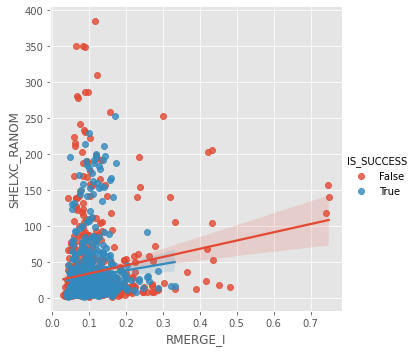

criterion            entropy
max_depth                  7
max_features              21
max_leaf_nodes            20
min_samples_leaf           1
min_samples_split         11
n_estimators            7154
Name: 0, dtype: object
Normal
> F1 Score: 70.93% +- 0.63%
> MCC: 39.72% +- 1.60%
PCA
> F1 Score: 71.57% +- 0.87%
> MCC: 40.56% +- 2.05%
Remove
> F1 Score: 72.11% +- 1.29%
> MCC: 41.92% +- 2.34%


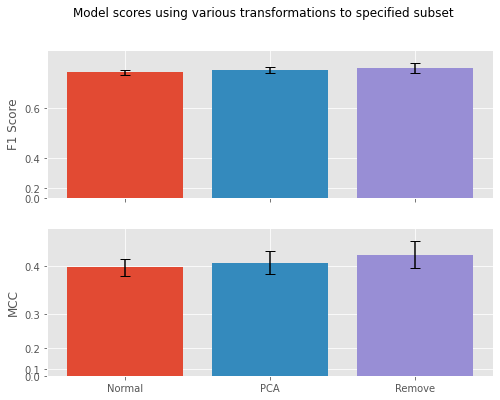

In [37]:
for db_kind, datum in data.items():
    print(db_kind.upper())
    x, y = datum.unpack(drop_col=["DATASET_id", "SHELXC_CFOM", "SPACEGROUP"])
    
    # take only untouched data
    i = 1
    mask = x["DATASET_NAME"] == i
    x, y, = x[mask], y[mask]
    x = x.drop(["DATASET_NAME"], axis=1)
    
    # get relevant features
    feats2test = ["RMERGE_I", "RMERGE_DIFF_I", "RMEAS_I", "RMEAS_DIFF_I", "RPIM_I", "RPIM_DIFF_I",
                  "SHELXC_RPIM", "SHELXC_RANOM", "SHELXC_MULTIPLICITY", "F''", "CC_HALF"]
    print(f"Removing features: {feats2test}")
    x_part = x[feats2test]
    union_part = pd.concat([x_part, y], axis=1)
    
    # plot scatter plot
    sns.lmplot(data=union_part, x=feats2test[0], y=feats2test[7], hue="IS_SUCCESS")
    plt.show()
    
    
    # prepare best params
    db_dir = fr"D:\Diamond\analysis\results\dataset_{i}\{db_kind}\confidence_threshold"
    best_params = pd.read_csv(os.path.join(db_dir, "best_params_RandomForest.csv"), squeeze=True, index_col=0)
    best_params.index = best_params.index.str.replace("clf__", "")
    for ix, val in best_params.items():
        try:
            best_params[ix] = int(val)
        except ValueError:
            continue
    print(best_params)
    best_params = best_params.to_dict()
    
    # create estimators
    seed = 1
    clf = RandomForestClassifier(class_weight="balanced", **best_params)
    model = Pipeline([("scaler", StandardScaler()), ("clf", clf)])
    
    
    # test various features transforms
    fig, (ax1, ax2) = test_normal_pca_remove(model, x, y, feats2test, show=False)
    ax1.set_yscale('function', functions=(lambda a: a**2, lambda a: a**.5))
    ax2.set_yscale('function', functions=(lambda a: a**2, lambda a: a**.5))
    
    plt.show()

Doing **PCA or removing these 11 features either improves, or does not significantly change, the performance**. This is clearer on the MCC. The increase is not significant, however the simple fact of the performance not decreasing is already enough to state these features aren't of much importance to the model.

As always, there will be some random deviation from this, but the general trend appears to be as described.

I finally conclude that, from my experimentation so far, **these 11 features can safely be dropped**.